# Object Detection For Autonomous Driving

## Objective

The goal of this assignment is to fine-tune the YOLO object detection model on a subset of the KITTI dataset, widely used in autonomous driving research. The KITTI dataset provides annotated images for tasks like object detection, tracking, and segmentation, making it ideal for training models to detect objects such as cars, pedestrians, and cyclists.

By completing this assignment, you will gain hands-on experience in dataset preparation, annotation conversion, model training, and performance evaluation using metrics like mAP (mean Average Precision). Additionally, you will explore the trade-offs between speed and accuracy, crucial for real-time applications like autonomous driving.


## Introduction: Object Detection

Object detection is a fundamental task in computer vision that involves identifying and localizing objects within an image or video. 

The main techniques for object detection include traditional methods like sliding window and region-based approaches, as well as modern deep learning-based methods such as YOLO (You Only Look Once), SSD (Single Shot MultiBox Detector), and Faster R-CNN. These techniques leverage convolutional neural networks (CNNs) to extract features and predict bounding boxes and class labels for objects in real-time or near real-time. 

Widely used models for object detection include:
- **YOLO (You Only Look Once)**: Known for its speed and efficiency in real-time applications.
- **Faster R-CNN**: A two-stage detector that provides high accuracy but is slower compared to single-stage detectors.
- **SSD (Single Shot MultiBox Detector)**: Balances speed and accuracy, making it suitable for various applications.
- **RetinaNet**: Introduces the focal loss to address class imbalance in object detection.
- **EfficientDet**: A family of models that optimize both accuracy and efficiency using compound scaling.

In the context of autonomous vehicles, object detection plays a critical role in perceiving the environment, identifying obstacles, pedestrians, traffic signs, and other vehicles. This capability enables autonomous systems to make informed decisions, ensuring safety and efficiency in navigation and driving scenarios.

## YOLO

YOLO (You Only Look Once) is a state-of-the-art, real-time object detection system. Unlike traditional object detection methods that apply a classifier to different regions of an image, YOLO frames object detection as a single regression problem. It predicts bounding boxes and class probabilities directly from full images in one evaluation, making it extremely fast and efficient.

### Model

The YOLO model divides the input image into a grid, where each grid cell is responsible for predicting bounding boxes and their associated class probabilities. Key features of YOLO include:

- **Unified Architecture**: YOLO uses a single convolutional neural network (CNN) to predict multiple bounding boxes and class probabilities simultaneously.
- **Speed**: YOLO is optimized for real-time applications, capable of processing images at high frame rates.
- **Global Context**: By considering the entire image during training and inference, YOLO reduces false positives and improves detection accuracy.
- **Versions**: Over time, YOLO has evolved through multiple versions (e.g., YOLOv1 up to YOLOv11), each introducing architectural improvements, better loss functions, and enhanced performance.

YOLO is widely used in applications such as autonomous driving, surveillance, and robotics, where real-time object detection is critical.

For more details on YOLO, visit the [Ultralytics GitHub repository](https://github.com/ultralytics/ultralytics).

## Theory Questions


For the next questions, focus on the latest version of the model, YOLOv11

Briefly describe the architecture used in YOLOv11 and the different losses used during training.

ANS:

The following [picture](https://medium.com/@nikhil-rao-20/yolov11-explained-next-level-object-detection-with-enhanced-speed-and-accuracy-2dbe2d376f71) summarize the architecture of the YOLOv11

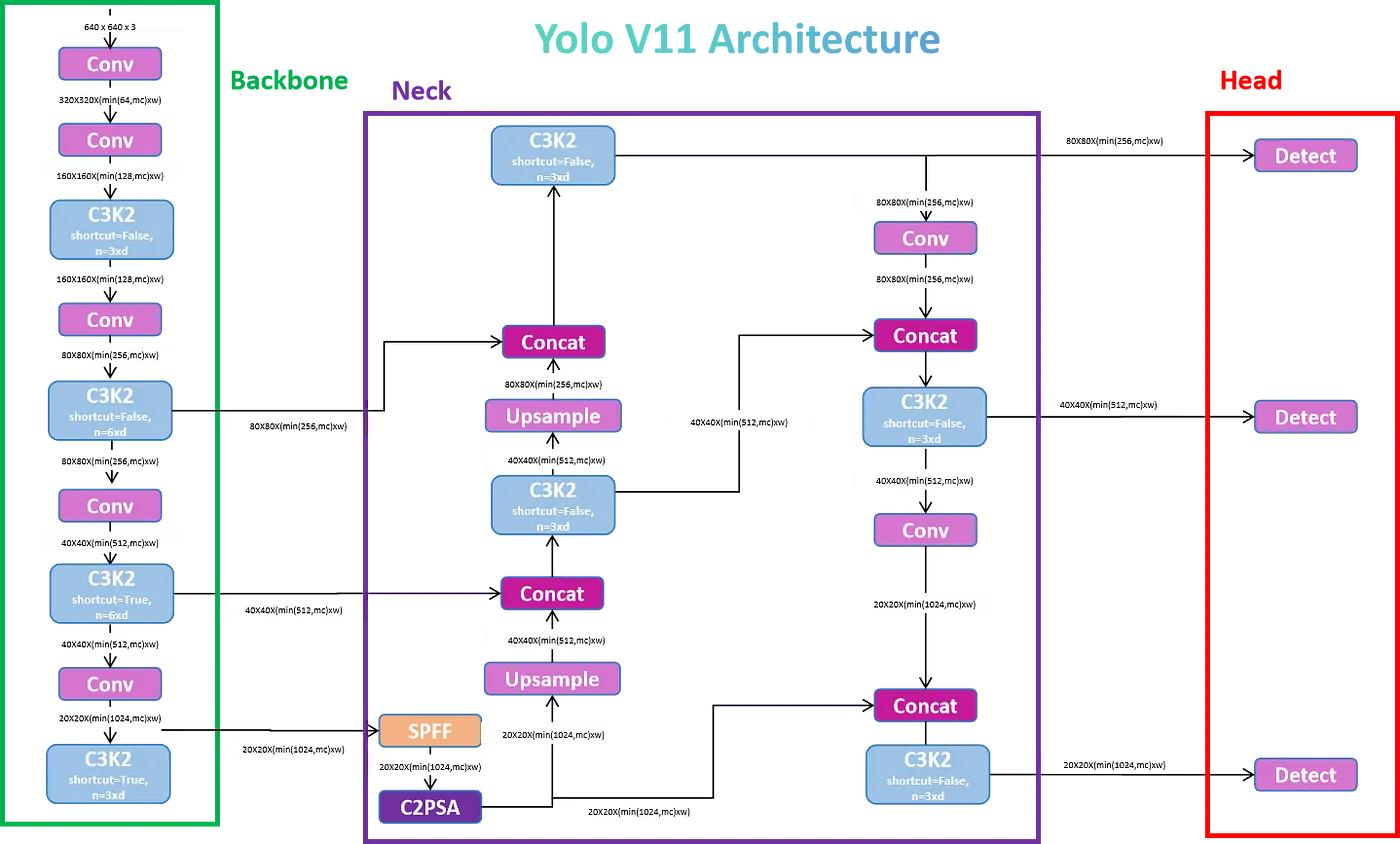


What are the metrics used to assess YOLO's performance for object detection?

ANS:

## Code

In the next part of the assignment, you will load a YOLO model and fine-tune it on the provided subset of the KITTI dataset.
You will then visualize the training losses and evaluate the model by running inference to assess its performance.

In [1]:
# !pip install ultralytics opencv-python-headless -q

In [2]:
import os, cv2, glob, random, shutil, requests, zipfile
from ultralytics import YOLO

import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline

from IPython.display import Image, display
import glob 

import yaml
import cv2
import matplotlib.pyplot as plt
import glob

In [3]:
# ---------------------------------------------
# STEP 1: Setup paths
# ---------------------------------------------
HOME = os.getcwd()
DATASET_PATH = os.path.join(HOME, "datasets", "kitti_subset")
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
LABELS_PATH = os.path.join(DATASET_PATH, "labels")

TRAIN_IMG = os.path.join(IMAGES_PATH, "train")
VAL_IMG = os.path.join(IMAGES_PATH, "val")
TEST_IMG = os.path.join(IMAGES_PATH, "test")
TRAIN_LABEL = os.path.join(LABELS_PATH, "train")
VAL_LABEL = os.path.join(LABELS_PATH, "val")
TEST_LABEL = os.path.join(LABELS_PATH, "test")

for path in [TRAIN_IMG, VAL_IMG, TEST_IMG, TRAIN_LABEL, VAL_LABEL, TEST_LABEL]:
    os.makedirs(path, exist_ok=True)

# ---------------------------------------------
# STEP 2: Download and extract KITTI data
# ---------------------------------------------
KITTI_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip"
KITTI_LABELS_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip"

def download_and_extract(url, extract_to):
    zip_path = os.path.join(HOME, url.split("/")[-1])
    if not os.path.exists(zip_path):
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete.")

    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

download_and_extract(KITTI_URL, IMAGES_PATH)
download_and_extract(KITTI_LABELS_URL, LABELS_PATH)

# ---------------------------------------------
# STEP 3: Convert KITTI annotations to YOLO
# ---------------------------------------------
CLASS_MAP = {"Car": 0, "Pedestrian": 1, "Cyclist": 2}

def convert_kitti_to_yolo(kitti_label_path, yolo_label_path, image_path):
    with open(kitti_label_path, "r") as file:
        lines = file.readlines()

    img = cv2.imread(image_path)
    if img is None:
        return
    height, width, _ = img.shape

    with open(yolo_label_path, "w") as yolo_file:
        for line in lines:
            elements = line.split()
            class_name = elements[0]
            if class_name not in CLASS_MAP:
                continue  # Skip irrelevant classes

            class_id = CLASS_MAP[class_name]
            x1, y1, x2, y2 = map(float, elements[4:8])

            # Convert to YOLO format
            center_x = ((x1 + x2) / 2) / width
            center_y = ((y1 + y2) / 2) / height
            bbox_width = (x2 - x1) / width
            bbox_height = (y2 - y1) / height

            yolo_file.write(f"{class_id} {center_x:.6f} {center_y:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# ---------------------------------------------
# STEP 4: Prepare dataset (subset, split, convert)
# ---------------------------------------------
all_images = sorted(glob.glob(os.path.join(IMAGES_PATH, "training", "image_2", "*.png")))
all_labels = sorted(glob.glob(os.path.join(LABELS_PATH, "training", "label_2", "*.txt")))

paired_data = list(zip(all_images, all_labels))
random.seed(42)
random.shuffle(paired_data)

# Keep small subset (e.g., 300 images total)
subset_data = paired_data[:300]
train_size = int(0.8 * len(subset_data))
val_size = int(0.1 * len(subset_data))

train_data = subset_data[:train_size]
val_data = subset_data[train_size:train_size + val_size]
test_data = subset_data[train_size + val_size:]

def move_and_convert_files(data, img_dest, lbl_dest):
    for img_path, lbl_path in data:
        new_img_path = os.path.join(img_dest, os.path.basename(img_path))
        new_lbl_path = os.path.join(lbl_dest, os.path.basename(lbl_path))
        shutil.copy2(img_path, new_img_path)
        convert_kitti_to_yolo(lbl_path, new_lbl_path, new_img_path)

move_and_convert_files(train_data, TRAIN_IMG, TRAIN_LABEL)
move_and_convert_files(val_data, VAL_IMG, VAL_LABEL)
move_and_convert_files(test_data, TEST_IMG, TEST_LABEL)


# ---------------------------------------------
# STEP 5: Create data.yaml
# ---------------------------------------------
data_yaml = f"""
path: {DATASET_PATH}
train: images/train
val: images/val
test: images/test

nc: 3
names: ['Car', 'Pedestrian', 'Cyclist']
"""

with open(os.path.join(DATASET_PATH, "data.yaml"), "w") as f:
    f.write(data_yaml)



Extracting /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/data_object_image_2.zip...
Extraction complete.
Extracting /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/data_object_label_2.zip...
Extraction complete.


In [4]:
# ---------------------------------------------
# STEP 6: Fine-tune YOLOv11 model
# ---------------------------------------------
#TO-DO: Add the code to fine-tune the YOLOv5 model
model = YOLO("yolo11x.pt")

# Train the model
model.train(data=os.path.join(DATASET_PATH, "data.yaml"), epochs=20, imgsz=640, device="0", batch=6)

New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.97 🚀 Python-3.13.2 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7817MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/data.yaml, epochs=20, time=None, patience=100, batch=6, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=F

train: Scanning /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/labels/train.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
val: Scanning /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/labels/val.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.000515625), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train14
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.44G      1.526       1.87      1.259         69        640: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

                   all         30        128      0.222      0.475       0.26      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.76G      1.608      1.803      1.353         97        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         30        128      0.117      0.387      0.128     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.78G      1.856      2.414       1.51         58        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         30        128      0.419      0.182      0.136     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.78G      1.996      2.079       1.56        106        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         30        128       0.36     0.0833     0.0541     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.11G       1.75      1.612      1.503         47        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         30        128     0.0589      0.257     0.0323     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.69G      1.632      1.331      1.387         32        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         30        128      0.569      0.288      0.128     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.81G      1.536      1.171      1.323         43        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         30        128      0.756      0.262       0.32      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.03G      1.532      1.141      1.337         54        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

                   all         30        128      0.419       0.42      0.407      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.71G      1.463      1.103      1.322         30        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         30        128      0.756      0.372      0.479      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       6.8G      1.415      1.061      1.265         40        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         30        128      0.745      0.583      0.577      0.335


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.03G      1.382      1.121      1.248         15        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         30        128      0.837      0.608      0.622      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.69G      1.309       1.01      1.227         29        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         30        128      0.557      0.547      0.516      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.78G      1.311      1.039      1.219         41        640: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         30        128      0.621      0.498      0.578      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.99G      1.319     0.9549      1.203         46        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         30        128      0.723      0.543      0.587      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.69G      1.259     0.9277      1.184         28        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         30        128      0.828      0.586        0.6      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.79G      1.243     0.8662      1.191         33        640: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         30        128      0.781      0.614      0.615      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.99G      1.227     0.8773       1.15         29        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         30        128       0.89      0.596      0.626      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.67G        1.2     0.8334      1.136         32        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         30        128      0.876      0.559      0.626       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.78G      1.121     0.7739      1.118         23        640: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         30        128      0.776       0.61      0.634      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.99G      1.112     0.7903      1.117         28        640: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         30        128      0.874      0.589      0.655       0.43



20 epochs completed in 0.231 hours.
Optimizer stripped from runs/detect/train14/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train14/weights/best.pt, 114.4MB

Validating runs/detect/train14/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.13.2 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7817MiB)
YOLO11x summary (fused): 190 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


                   all         30        128      0.873       0.59      0.655      0.431
                   Car         26        108      0.862      0.812      0.892      0.628
            Pedestrian          7         16      0.758        0.5      0.557      0.348
               Cyclist          3          4          1      0.457      0.515      0.317
Speed: 0.2ms preprocess, 20.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train14


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fbd53e90e10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# Inference

After training, visualize the losses andmetrics calculated on the validation set during training.

Additionally, make sure you visualize the confusion matrix to see per-class errors.

For qualitative analysis, run inference on the model, visualise the bouding boxes and visually assess it.

In [5]:
# -------- VISUALIZE TRAINING LOSSES AND METRICS --------
#TO-DO: Add the code to visualize the training losses and metrics

In [6]:
# ------ VISUALIZE CONFUSION MATRIX --------
#TO-DO: Add the code to visualize the confusion matrix

In [7]:
# -------- RUN INFERENCE AND PLOT SAMPLE OUTPUTS --------
#TO-DO: Add the code to run inference and visualize the outputs results


## Question

Comment on the performance of the model based on the visualizations you made and discuss the inference speed versus performance for YOLO on the driving datasets. Do you think we can use YOLO online on autonomous cars? 

## Ans